# Import Libraries

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns
import numpy as np
from numpy import int64
import json

import datetime as dt
from datetime import timedelta
from datetime import datetime
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX



pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', None)

# Functions

In [22]:
def clean_str(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        u"!"
                      "]+", re.UNICODE)
    
    clean_str = re.sub(emoj, '', data)

    clean_str = clean_str.strip()
    return clean_str



def plot_pareto(label,total,cumperc):
    #define aesthetics for plot
    color1 = 'steelblue'
    color2 = 'red'
    line_size = 4

    #create basic bar plot
    fig, ax = plt.subplots()
    ax.bar(label, total, color=color1)
    # fig.xticks(rotation=90)

    #add cumulative percentage line to plot
    ax2 = ax.twinx()
    ax2.plot(label, cumperc, color=color2, marker="D", ms=line_size)

    #specify axis colors
    ax.tick_params(axis='y', colors=color1, labelrotation=0)
    ax2.tick_params(axis='y', colors=color2)
    ax.tick_params(axis='x', labelrotation=45)

    ax.set_ylabel('Sales Value Before Discount (includ. VAT) (EUR)')
    ax2.set_ylabel('Running Percentage')
    ax.set_xlabel('Category Level 0')

    #display Pareto chart
    plt.show()




    




# Data Gathering

In [13]:
df_sda = pd.read_excel('SDA, Delivery - h_t.xlsx')

# Data Cleaning

In [14]:
df_sda_clean = df_sda.copy()

for category_level in ['Category level 0','Category level 1','Category level 2']:
    df_sda_clean[category_level] = df_sda_clean[category_level].apply(lambda x: clean_str(x))

df_sda_clean['Week'] = df_sda_clean['Time'].dt.isocalendar().week
df_sda_clean['Year'] = df_sda_clean['Time'].dt.year
df_sda_clean['Year-Week'] = df_sda_clean['Year'].astype(str) + '-' + df_sda_clean['Week'].astype(str)

df_sda_clean['Unique SKUs Listed'] = np.where(
    df_sda_clean['Unique SKUs Sold'] > df_sda_clean['Unique SKUs Listed'],
    df_sda_clean['Unique SKUs Sold'],
    df_sda_clean['Unique SKUs Listed']
)

df_sda_clean = df_sda_clean.rename(columns={'Price before Discount (includ. VAT) (EUR)':'Sales Value Before Discount (includ. VAT) (EUR)'})

df_sda_clean['Sales Value After Discount (includ. VAT) (EUR)'] = df_sda_clean['Sales Value Before Discount (includ. VAT) (EUR)'] - df_sda_clean['Discount Value (EUR)']

df_sda_clean['Category level 0-1'] = df_sda_clean['Category level 0'] + '|' + df_sda_clean['Category level 1']

df_sda_clean['Category level 0-2'] = df_sda_clean['Category level 0'] + '|' + df_sda_clean['Category level 1'] + '|' + df_sda_clean['Category level 2']

df_sda_clean['assortment_performance'] = df_sda_clean['Unique SKUs Sold'] / df_sda_clean['Unique SKUs Listed']

df_sda_clean = df_sda_clean.loc[
    ~(df_sda_clean['Year-Week'] == '2023-26')
]

In [15]:
df_sda_clean

,Time,Category level 0,Category level 1,Category level 2,Unique SKUs Listed,Unique SKUs Sold,# of sold SKU items,Sales Value Before Discount (includ. VAT) (EUR),Discount Value (EUR),Item COGS (net VAT) (EUR),"Waste, # of items",Week,Year,Year-Week,Sales Value After Discount (includ. VAT) (EUR),Category level 0-1,Category level 0-2,assortment_performance
0,2023-09-17,Fresh Food,Cheese,Hard Cheese,26,17,37,135.81259,10.49147,88.81738,0,37,2023,2023-37,125.32112,Fresh Food|Cheese,Fresh Food|Cheese|Hard Cheese,0.65385
1,2023-08-02,Fresh Food,Bakery,Gluten Free,1,0,0,0.00000,0.00000,0.00000,0,31,2023,2023-31,0.00000,Fresh Food|Bakery,Fresh Food|Bakery|Gluten Free,0.00000
2,2023-08-26,Fresh Food,Dairy & Eggs,Sour Cream & Cream,14,10,26,53.45451,3.21331,31.87778,0,34,2023,2023-34,50.24120,Fresh Food|Dairy & Eggs,Fresh Food|Dairy & Eggs|Sour Cream & Cream,0.71429
3,2023-09-24,Fresh Food,Fresh & Ready,Desserts & Sweets,25,13,47,61.69856,3.51652,41.22566,0,38,2023,2023-38,58.18204,Fresh Food|Fresh & Ready,Fresh Food|Fresh & Ready|Desserts & Sweets,0.52000
4,2023-09-15,Fresh Food,Meat & Fish,Meat & Fish Alternatives,17,3,8,13.06156,1.35807,8.68154,0,37,2023,2023-37,11.70350,Fresh Food|Meat & Fish,Fresh Food|Meat & Fish|Meat & Fish Alternatives,0.17647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17396,2023-07-04,Other,Save me,Packaging fee,1,1,654,170.40689,83.64008,104.35878,0,27,2023,2023-27,86.76681,Other|Save me,Other|Save me|Packaging fee,1.00000
17397,2023-09-26,Other,Save me,Packaging fee,1,1,585,151.75661,74.19212,92.93895,0,39,2023,2023-39,77.56449,Other|Save me,Other|Save me|Packaging fee,1.00000
17398,2023-08-21,Other,Save me,Packaging fee,1,1,653,170.55903,86.45488,104.45388,0,34,2023,2023-34,84.10415,Other|Save me,Other|Save me|Packaging fee,1.00000
17399,2023-07-28,Other,Save me,Packaging fee,1,1,620,162.16348,83.17417,99.31160,0,30,2023,2023-30,78.98931,Other|Save me,Other|Save me|Packaging fee,1.00000


# Discovery Data

In [16]:
df_sda_disc = df_sda_clean.copy()

first_date = np.min(df_sda_disc['Time'])
last_date = np.max(df_sda_disc['Time'])

print(f'Time Range: {first_date} - {last_date}') # tree months - 3 qurter year 2023

df_sda_disc.sort_values(by='# of sold SKU items',ascending=False)

df_sda_disc.loc[
    (df_sda_disc['Category level 0'] == 'Grocery Food') &
    (df_sda_disc['Category level 1'] == 'Water & Flavoured Water') &
    (df_sda_disc['Category level 2'] == 'Still Water')
].sort_values(by='Time') # AGREGATION LEVEL: TIME / CAT 2

df_sda_disc.sort_values(by='Discount Value (EUR)') # Negative discount? Return maybe? 


df_sda_disc.loc[
    (df_sda_disc['Category level 0'] == 'Grocery Non-Food') &
    (df_sda_disc['Category level 1'] == 'Tobacco & Heated Tobacco') &
    (df_sda_disc['Category level 2'] == 'Cigarettes & Cigars')
].sort_values(by='Discount Value (EUR)',ascending=False) # Negative discount I will considered as Refunds and Returns. That hardly could be further than that because we are missing information about returns

print(df_sda_disc['Category level 0'].unique())


df_sda_disc[['Category level 0','Category level 1']].drop_duplicates() #'Fresh Food' 'Grocery Food' 'Grocery Non-Food' are the main deal of business


df_sda_disc.loc[
    df_sda_disc['Category level 0'] == 'Other'
][['Category level 0','Category level 1','Category level 2']].drop_duplicates() # Other is just Packing Fee


df_sda_disc.loc[
    df_sda_disc['Category level 0'] == 'Not defined'
][['Category level 0','Category level 1','Category level 2']].drop_duplicates() # Not defined doesnt have relevance in the business


df_sda_disc.loc[
    (df_sda_disc['Category level 0'] == 'Grocery Food') &
    (df_sda_disc['Category level 1'] == 'Water & Flavoured Water') &
    (df_sda_disc['Category level 2'] == 'Still Water')
].sort_values(by='Time') # AGREGATION LEVEL: TIME / CAT 2


df_sda_disc.groupby(by='Year-Week')['# of sold SKU items'].sum().reset_index() # Removing Week 26 per lack of data. 

Time Range: 2023-07-03 00:00:00 - 2023-09-30 00:00:00
['Fresh Food' 'Grocery Food' 'Grocery Non-Food' 'Not defined' 'Other']


,Year-Week,# of sold SKU items
0,2023-27,53564
1,2023-28,55330
2,2023-29,51745
3,2023-30,52372
4,2023-31,49990
5,2023-32,48399
6,2023-33,46797
7,2023-34,53111
8,2023-35,53925
9,2023-36,54564


# Insights

## Categories Performance

Analyze the performance of different product categories to provide insights into which categories are driving the most revenue. This information can guide category management and content strategy.

### Totals & Perc

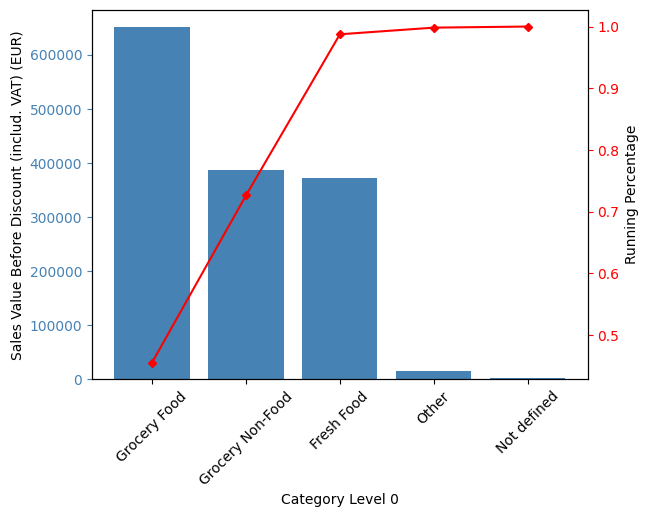

,Category level 0,total_sold_SKU_items,total_sales_value_before_discount,total_discount_value,total_item_COGS,profit,product_margin,running_total_sales,running_perc_total_sales
0,Grocery Food,328493,650539.58808,35384.08970,398705.11904,251834.46904,0.38712,650539.58808,0.45572
1,Grocery Non-Food,87209,386333.48131,4308.05995,284755.94728,101577.53403,0.26293,1036873.06940,0.72636
2,Fresh Food,190129,372752.09712,26430.64235,240356.04434,132396.05278,0.35519,1409625.16651,0.98748
3,Other,58995,15376.68938,7750.78586,9416.77660,5959.91278,0.38759,1425001.85590,0.99825
4,Not defined,930,2499.69171,204.24643,1551.13003,948.56168,0.37947,1427501.54760,1.00000


In [23]:
df_sda_cat = df_sda_clean.copy()

# print(df_sda_cat_perf.columns)
df_sda_cat_0 = df_sda_cat.groupby(by='Category level 0').agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_item_COGS = ('Item COGS (net VAT) (EUR)','sum')
    ).reset_index()


df_sda_cat_0['profit'] = df_sda_cat_0['total_sales_value_before_discount'] - df_sda_cat_0['total_item_COGS']

df_sda_cat_0['product_margin'] = (df_sda_cat_0['total_sales_value_before_discount'] - df_sda_cat_0['total_item_COGS']) / df_sda_cat_0['total_sales_value_before_discount']

df_sda_cat_0 = df_sda_cat_0.sort_values(by='total_sales_value_before_discount',ascending=False).reset_index(drop=True)

df_sda_cat_0['running_total_sales'] = np.cumsum(df_sda_cat_0['total_sales_value_before_discount'])

df_sda_cat_0['running_perc_total_sales'] = df_sda_cat_0['running_total_sales'] / np.sum(df_sda_cat_0['total_sales_value_before_discount'])

plot_pareto(label=df_sda_cat_0['Category level 0'],total=df_sda_cat_0['total_sales_value_before_discount'],cumperc=df_sda_cat_0['running_perc_total_sales'])

df_sda_cat_0

In [70]:
df_sda_cat = df_sda_clean.copy()

# print(df_sda_cat_perf.columns)
df_sda_cat_0 = df_sda_cat.groupby(by='Category level 0-1').agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_item_COGS = ('Item COGS (net VAT) (EUR)','sum')
    ).reset_index()


df_sda_cat_0['profit'] = df_sda_cat_0['total_sales_value_before_discount'] - df_sda_cat_0['total_item_COGS']

df_sda_cat_0['product_margin'] = (df_sda_cat_0['total_sales_value_before_discount'] - df_sda_cat_0['total_item_COGS']) / df_sda_cat_0['total_sales_value_before_discount']

df_sda_cat_0 = df_sda_cat_0.sort_values(by='total_sales_value_before_discount',ascending=False).reset_index(drop=True)

df_sda_cat_0['running_total_sales'] = np.cumsum(df_sda_cat_0['total_sales_value_before_discount'])

df_sda_cat_0['running_perc_total_sales'] = df_sda_cat_0['running_total_sales'] / np.sum(df_sda_cat_0['total_sales_value_before_discount'])

df_sda_cat_0.head(10)[['Category level 0-1','total_sales_value_before_discount']]

,Category level 0-1,total_sales_value_before_discount
0,Grocery Non-Food|Tobacco & Heated Tobacco,284075.25124
1,Grocery Food|Beverages,97568.51201
2,Grocery Food|Water & Flavoured Water,90122.18704
3,Fresh Food|Fruits & Vegetables,86791.30642
4,Fresh Food|Dairy & Eggs,82958.52657
5,Grocery Food|Ice Cream,82591.73464
6,Fresh Food|Meat & Fish,71208.23035
7,Grocery Food|Wine,69696.64031
8,Grocery Food|Beer & Cider,64909.87735
9,Grocery Food|Salty Snacks,56236.29224


### TimeSeries and Heatmap - Cat 0 and 1

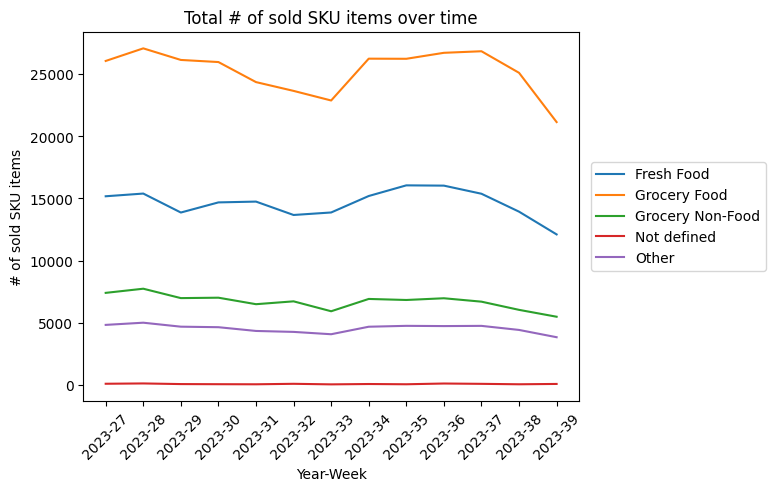

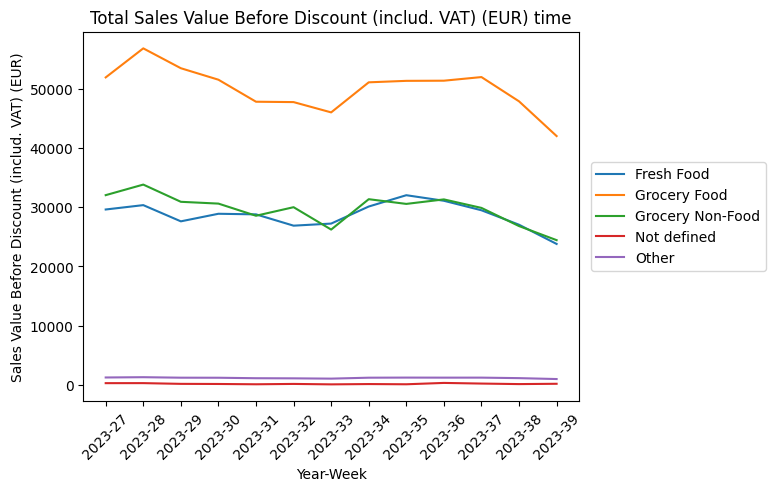

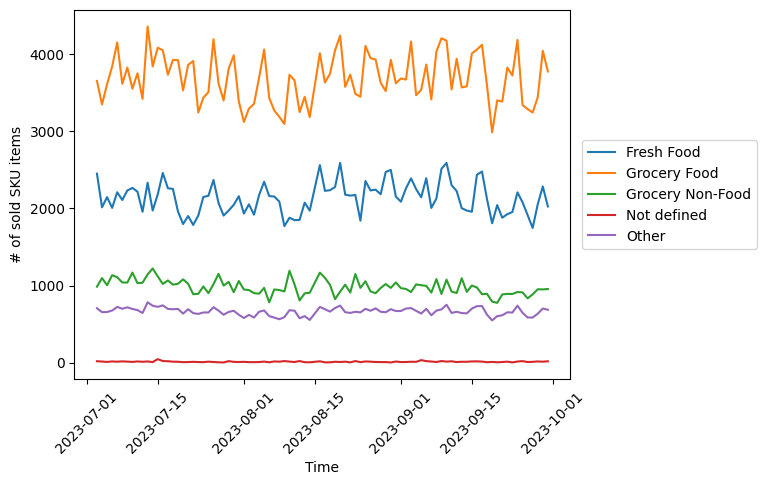

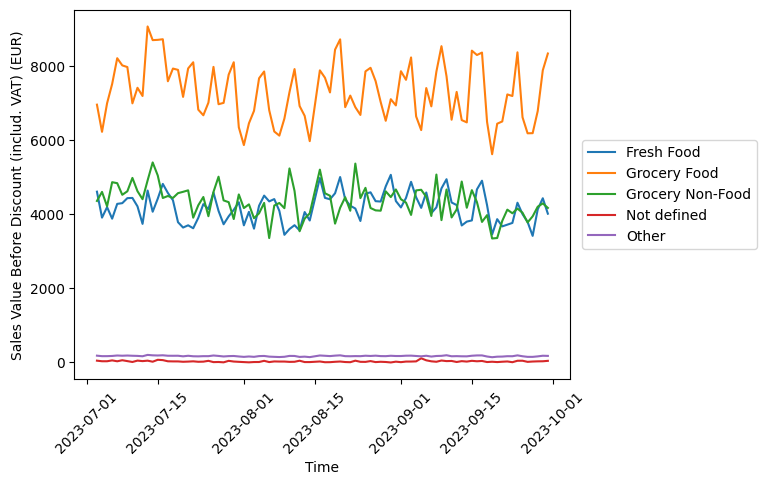

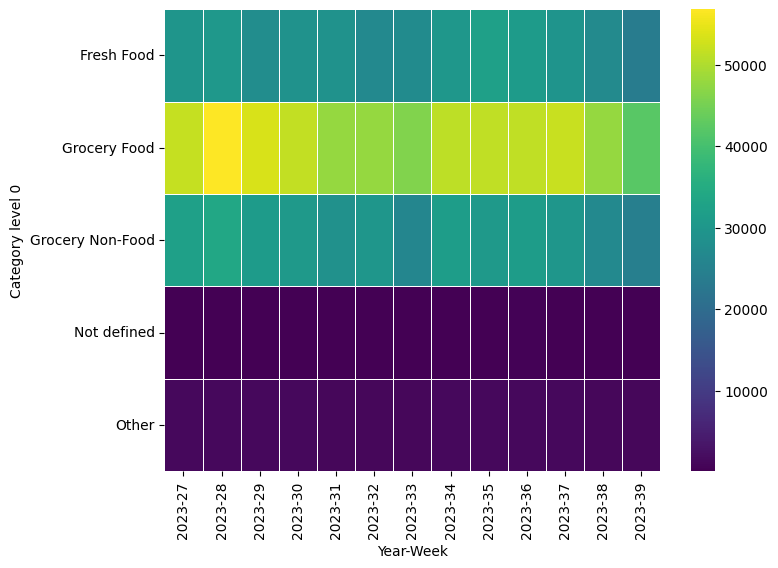

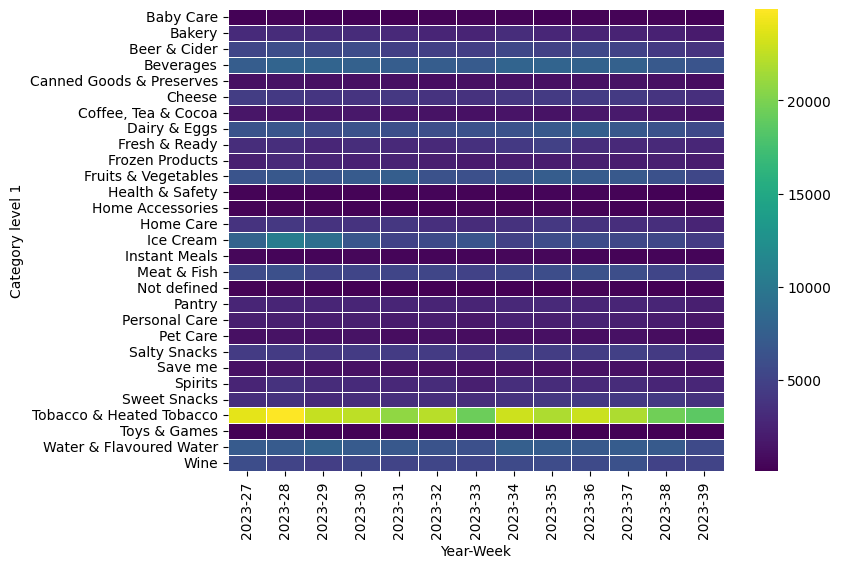

In [29]:
df_sda_cat_heat = df_sda_clean.copy()


df_sda_cat_heat_0 = df_sda_cat_heat.groupby(by=['Year-Week','Category level 0']).agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_item_COGS = ('Item COGS (net VAT) (EUR)','sum')
    ).reset_index()

df_sda_cat_heat_0 = df_sda_cat_heat_0.rename(
    columns={
        'total_sold_SKU_items':'# of sold SKU items',
        'total_sales_value_before_discount':'Sales Value Before Discount (includ. VAT) (EUR)'
        })


sns.lineplot(
    x=df_sda_cat_heat_0['Year-Week'],
    y=df_sda_cat_heat_0['# of sold SKU items'],
    hue=df_sda_cat_heat_0['Category level 0']
)

plt.title('Total # of sold SKU items over time')
plt.legend(loc='center',bbox_to_anchor=(1.2, 0.5))
plt.xticks(rotation=45)

plt.show()



sns.lineplot(
    x=df_sda_cat_heat_0['Year-Week'],
    y=df_sda_cat_heat_0['Sales Value Before Discount (includ. VAT) (EUR)'],
    hue=df_sda_cat_heat_0['Category level 0']
)

plt.title('Total Sales Value Before Discount (includ. VAT) (EUR) time')
plt.legend(loc='center',bbox_to_anchor=(1.2, 0.5))
plt.xticks(rotation=45)

plt.show()



df_sda_cat_heat_0_day = df_sda_cat_heat.groupby(by=['Time','Category level 0']).agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_item_COGS = ('Item COGS (net VAT) (EUR)','sum')
    ).reset_index()

df_sda_cat_heat_0_day = df_sda_cat_heat_0_day.rename(
    columns={
        'total_sold_SKU_items':'# of sold SKU items',
        'total_sales_value_before_discount':'Sales Value Before Discount (includ. VAT) (EUR)'
        })


sns.lineplot(
    x=df_sda_cat_heat_0_day['Time'],
    y=df_sda_cat_heat_0_day['# of sold SKU items'],
    hue=df_sda_cat_heat_0_day['Category level 0']
)

plt.legend(loc='center',bbox_to_anchor=(1.2, 0.5))
plt.xticks(rotation=45)

plt.show()


sns.lineplot(
    x=df_sda_cat_heat_0_day['Time'],
    y=df_sda_cat_heat_0_day['Sales Value Before Discount (includ. VAT) (EUR)'],
    hue=df_sda_cat_heat_0_day['Category level 0']
)

plt.legend(loc='center',bbox_to_anchor=(1.2, 0.5))
plt.xticks(rotation=45)

plt.show()



df_sda_cat_heat_0 = df_sda_cat_heat_0.pivot(index='Category level 0',columns='Year-Week',values='Sales Value Before Discount (includ. VAT) (EUR)')


df_sda_cat_heat_1 = df_sda_cat_heat.groupby(by=['Year-Week','Category level 1'])['Sales Value Before Discount (includ. VAT) (EUR)'].sum().reset_index()
df_sda_cat_heat_1 = df_sda_cat_heat_1.pivot(index=['Category level 1'],columns='Year-Week',values='Sales Value Before Discount (includ. VAT) (EUR)')

plt.figure(figsize=(8, 6))

sns.heatmap(
    data=df_sda_cat_heat_0, cmap='viridis', linewidths=.5
    )

plt.show()

plt.figure(figsize=(8, 6))

sns.heatmap(
    data=df_sda_cat_heat_1, cmap='viridis', linewidths=.5
    )
plt.show()

### Price per SKU per Category

In [ ]:
df_sda_ticket = df_sda_clean.copy()

df_sda_ticket_cat_0 = df_sda_ticket.groupby(by=['Category level 0']).agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_sales_value_after_discount = ('Sales Value After Discount (includ. VAT) (EUR)','sum'),
    ).reset_index()

df_sda_ticket_cat_0['Discount Perc'] = df_sda_ticket_cat_0['total_discount_value'] / df_sda_ticket_cat_0['total_sales_value_before_discount']

df_sda_ticket_cat_0['Price per SKU Before Discount (includ. VAT) (EUR)'] = df_sda_ticket_cat_0['total_sales_value_before_discount'] / df_sda_ticket_cat_0['total_sold_SKU_items']

df_sda_ticket_cat_0['Price per SKU After Discount (includ. VAT) (EUR)'] = df_sda_ticket_cat_0['total_sales_value_after_discount'] / df_sda_ticket_cat_0['total_sold_SKU_items']

df_sda_ticket_cat_0 = df_sda_ticket_cat_0.sort_values(by='Price per SKU Before Discount (includ. VAT) (EUR)',ascending=False)

df_sda_ticket_cat_0

,Category level 0,total_sold_SKU_items,total_sales_value_before_discount,total_discount_value,total_sales_value_after_discount,Discount Perc,Price per SKU Before Discount (includ. VAT) (EUR),Price per SKU After Discount (includ. VAT) (EUR)
2,Grocery Non-Food,89360,395533.86814,4442.55888,391091.30926,0.01123,4.42630,4.37658
3,Not defined,960,2610.66357,208.99251,2401.67106,0.08005,2.71944,2.50174
1,Grocery Food,336804,666806.77874,36391.43824,630415.34049,0.05458,1.97981,1.87176
0,Fresh Food,195185,382221.06379,27112.87849,355108.18530,0.07094,1.95825,1.81934
4,Other,60464,15759.17165,7948.40412,7810.76752,0.50437,0.26064,0.12918


## Promotional Effectiveness

In [ ]:
df_sda_clean

,Time,Category level 0,Category level 1,Category level 2,Unique SKUs Listed,Unique SKUs Sold,# of sold SKU items,Sales Value Before Discount (includ. VAT) (EUR),Discount Value (EUR),Item COGS (net VAT) (EUR),"Waste, # of items",Week,Year,Year-Week,Sales Value After Discount (includ. VAT) (EUR),Category level 0-1,Category level 0-2
0,2023-09-17,Fresh Food,Cheese,Hard Cheese,26,17,37,135.81259,10.49147,88.81738,0,37,2023,2023-37,125.32112,Fresh Food|Cheese,Fresh Food|Cheese|Hard Cheese
1,2023-08-02,Fresh Food,Bakery,Gluten Free,1,0,0,0.00000,0.00000,0.00000,0,31,2023,2023-31,0.00000,Fresh Food|Bakery,Fresh Food|Bakery|Gluten Free
2,2023-08-26,Fresh Food,Dairy & Eggs,Sour Cream & Cream,14,10,26,53.45451,3.21331,31.87778,0,34,2023,2023-34,50.24120,Fresh Food|Dairy & Eggs,Fresh Food|Dairy & Eggs|Sour Cream & Cream
3,2023-09-24,Fresh Food,Fresh & Ready,Desserts & Sweets,25,13,47,61.69856,3.51652,41.22566,0,38,2023,2023-38,58.18204,Fresh Food|Fresh & Ready,Fresh Food|Fresh & Ready|Desserts & Sweets
4,2023-09-15,Fresh Food,Meat & Fish,Meat & Fish Alternatives,17,3,8,13.06156,1.35807,8.68154,0,37,2023,2023-37,11.70350,Fresh Food|Meat & Fish,Fresh Food|Meat & Fish|Meat & Fish Alternatives
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17396,2023-07-04,Other,Save me,Packaging fee,1,1,654,170.40689,83.64008,104.35878,0,27,2023,2023-27,86.76681,Other|Save me,Other|Save me|Packaging fee
17397,2023-09-26,Other,Save me,Packaging fee,1,1,585,151.75661,74.19212,92.93895,0,39,2023,2023-39,77.56449,Other|Save me,Other|Save me|Packaging fee
17398,2023-08-21,Other,Save me,Packaging fee,1,1,653,170.55903,86.45488,104.45388,0,34,2023,2023-34,84.10415,Other|Save me,Other|Save me|Packaging fee
17399,2023-07-28,Other,Save me,Packaging fee,1,1,620,162.16348,83.17417,99.31160,0,30,2023,2023-30,78.98931,Other|Save me,Other|Save me|Packaging fee


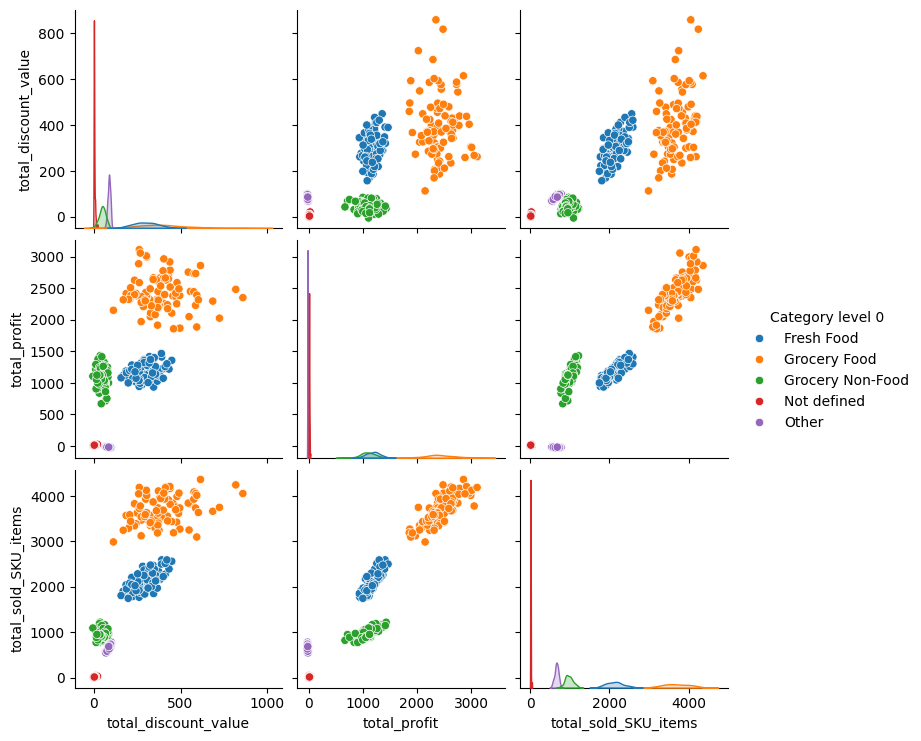

In [30]:
df_sda_promo =  df_sda_clean.copy()

df_sda_promo = df_sda_promo.groupby(by=['Time','Category level 0']).agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_unique_SKU_listed = ('Unique SKUs Listed','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_sales_value_after_discount = ('Sales Value After Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_item_COGS = ('Item COGS (net VAT) (EUR)','sum')
    ).reset_index()

df_sda_promo['Discount Perc'] = df_sda_promo['total_discount_value'] / df_sda_promo['total_sales_value_before_discount']


df_sda_promo['total_profit'] = df_sda_promo['total_sales_value_after_discount'] - df_sda_promo['total_item_COGS']



sns.pairplot(
    data=df_sda_promo[['Category level 0','total_discount_value','total_profit','total_sold_SKU_items']],
    hue='Category level 0'
)

plt.show()

In [31]:
df_sda_promo_reg =  df_sda_clean.copy()

df_sda_promo_reg = df_sda_promo_reg.groupby(by=['Time','Category level 0']).agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_unique_SKU_listed = ('Unique SKUs Listed','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_sales_value_after_discount = ('Sales Value After Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_item_COGS = ('Item COGS (net VAT) (EUR)','sum')
    ).reset_index()

df_sda_promo_reg['Discount Perc'] = df_sda_promo_reg['total_discount_value'] / df_sda_promo_reg['total_sales_value_before_discount']


df_sda_promo_reg['total_profit'] = df_sda_promo_reg['total_sales_value_after_discount'] - df_sda_promo_reg['total_item_COGS']


cat_list = ['Grocery Food','Fresh Food']

for cat in cat_list: 
    df_sda_promo_reg2 = df_sda_promo_reg.loc[
        df_sda_promo_reg['Category level 0'] ==cat
    ]

    X = df_sda_promo_reg2[['total_discount_value']]
    y = df_sda_promo_reg2['total_profit']
    X = sm.add_constant(X)

    mod = sm.OLS(y,X)
    fii = mod.fit()
    print(f'\n Results of OLS Regression for {cat}')
    print(fii.summary())


 Results of OLS Regression for Grocery Food
                            OLS Regression Results                            
Dep. Variable:           total_profit   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3759
Date:                Wed, 10 Jan 2024   Prob (F-statistic):              0.541
Time:                        00:36:06   Log-Likelihood:                -625.23
No. Observations:                  89   AIC:                             1254.
Df Residuals:                      87   BIC:                             1259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [63]:
df_sda_promo_reg =  df_sda_clean.copy()

df_sda_promo_reg = df_sda_promo_reg.groupby(by=['Time','Category level 0-1']).agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_unique_SKU_listed = ('Unique SKUs Listed','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_sales_value_after_discount = ('Sales Value After Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_item_COGS = ('Item COGS (net VAT) (EUR)','sum')
    ).reset_index()

df_sda_promo_reg['Discount Perc'] = df_sda_promo_reg['total_discount_value'] / df_sda_promo_reg['total_sales_value_before_discount']

df_sda_promo_reg['total_profit'] = df_sda_promo_reg['total_sales_value_after_discount'] - df_sda_promo_reg['total_item_COGS']

cat_list = df_sda_promo_reg['Category level 0-1'].unique()

for cat in cat_list: 
    df_sda_promo_reg2 = df_sda_promo_reg.loc[
        df_sda_promo_reg['Category level 0-1'] ==cat
    ]

    X = df_sda_promo_reg2[['total_discount_value']]
    y = df_sda_promo_reg2['total_profit']
    X = sm.add_constant(X)

    mod = sm.OLS(y, X)
    fii = mod.fit()

    # Filter results based on conditions (coef > 0 and p-value < 0.05)

    significant_results = fii.summary2().tables[1][['Coef.','P>|t|']]
    significant_results = significant_results[(significant_results.index == 'total_discount_value') & (significant_results['Coef.'] > 0) & (significant_results['P>|t|'] < 0.05)]
    # [
    #     (fii.summary2().tables[1]['Coef.'] > 0) & (fii.summary2().tables[1]['P>|t|'] < 0.05)
    # ]

    # Print the filtered results
    print(f'\nResults of OLS Regression for {cat} with Coef. > 0 and P-value < 0.05:')
    print(significant_results)


Results of OLS Regression for Fresh Food|Bakery with Coef. > 0 and P-value < 0.05:
Empty DataFrame
Columns: [Coef., P>|t|]
Index: []

Results of OLS Regression for Fresh Food|Cheese with Coef. > 0 and P-value < 0.05:
                       Coef.   P>|t|
total_discount_value 0.59550 0.00098

Results of OLS Regression for Fresh Food|Dairy & Eggs with Coef. > 0 and P-value < 0.05:
                       Coef.   P>|t|
total_discount_value 0.49036 0.00675

Results of OLS Regression for Fresh Food|Fresh & Ready with Coef. > 0 and P-value < 0.05:
                       Coef.   P>|t|
total_discount_value 1.05268 0.00000

Results of OLS Regression for Fresh Food|Fruits & Vegetables with Coef. > 0 and P-value < 0.05:
                       Coef.   P>|t|
total_discount_value 1.00182 0.00038

Results of OLS Regression for Fresh Food|Meat & Fish with Coef. > 0 and P-value < 0.05:
Empty DataFrame
Columns: [Coef., P>|t|]
Index: []

Results of OLS Regression for Grocery Food|Beer & Cider with Coef. >

In [61]:
significant_results

,Coef.,P>|t|
total_discount_value,0.40060,0.15217


## Clusters

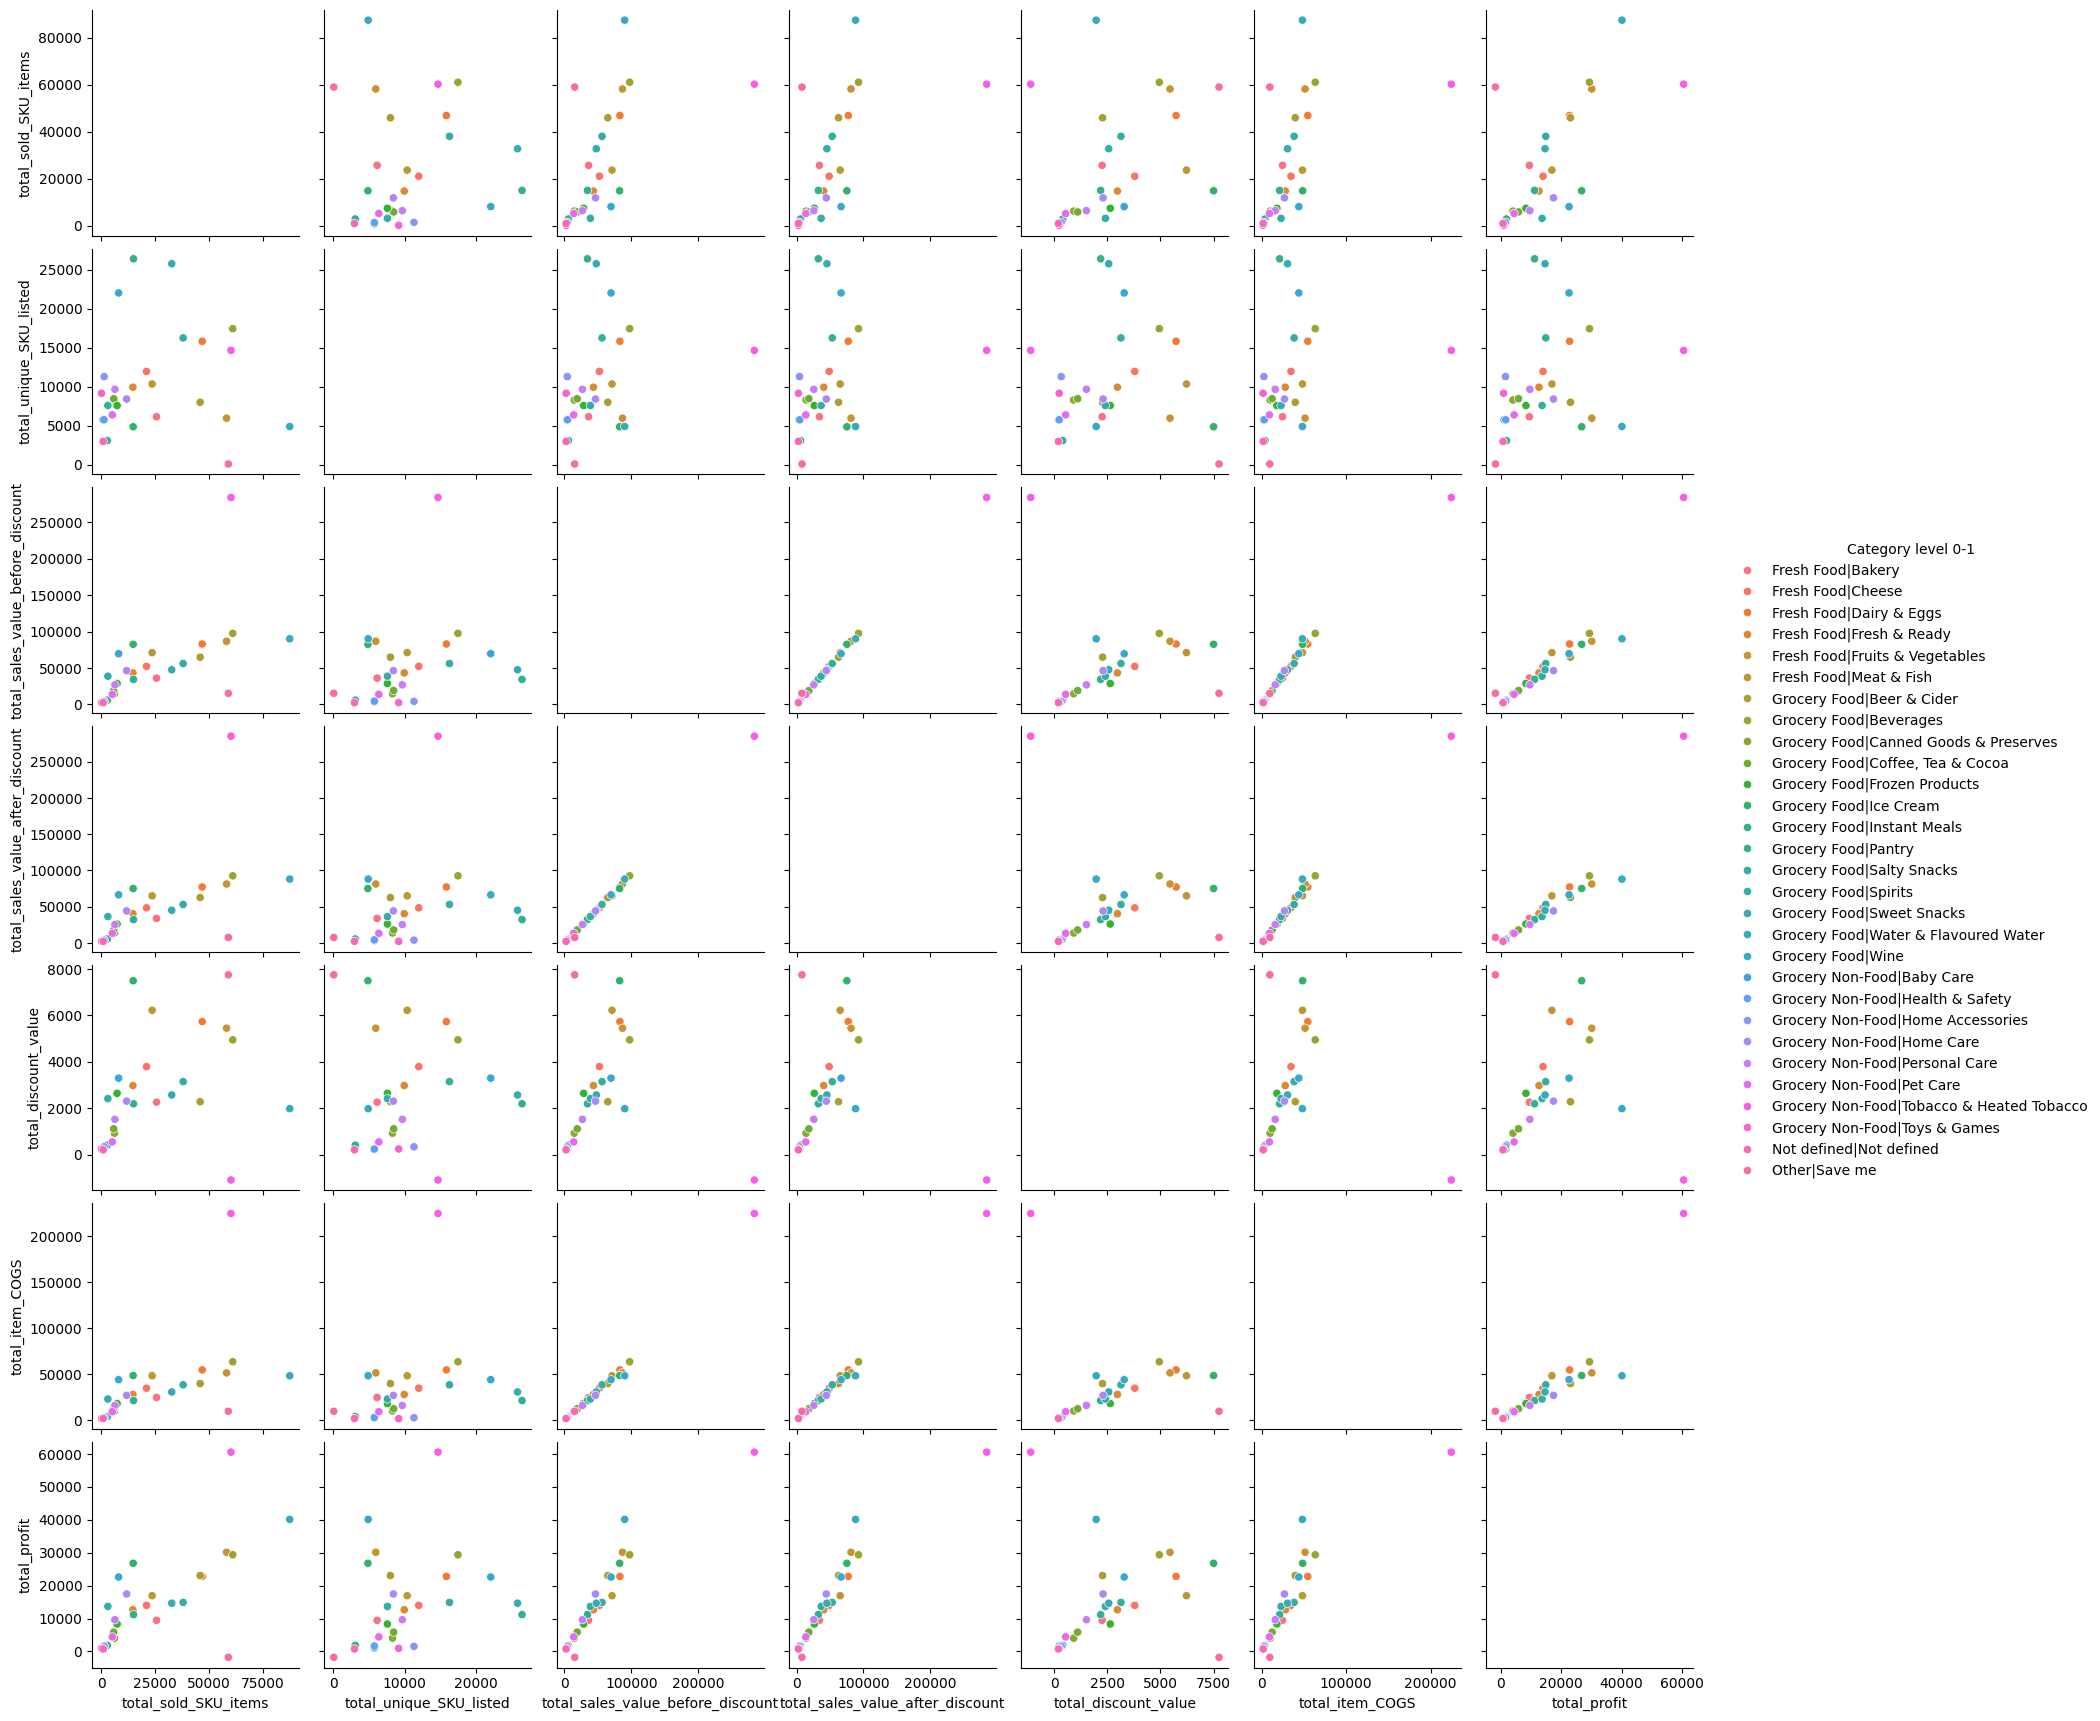

In [ ]:
df_sda_promo_cluster =  df_sda_clean.copy()

df_sda_promo_cluster = df_sda_promo_cluster.groupby(by=['Category level 0-1']).agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_unique_SKU_listed = ('Unique SKUs Listed','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_sales_value_after_discount = ('Sales Value After Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_item_COGS = ('Item COGS (net VAT) (EUR)','sum')
    ).reset_index()

df_sda_promo_cluster['total_profit'] = df_sda_promo_cluster['total_sales_value_after_discount'] - df_sda_promo_cluster['total_item_COGS']

sns.pairplot(
    data=df_sda_promo_cluster,
    hue='Category level 0-1'
)

plt.show()

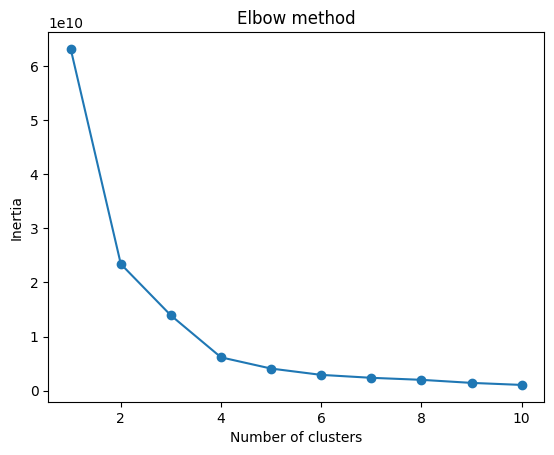

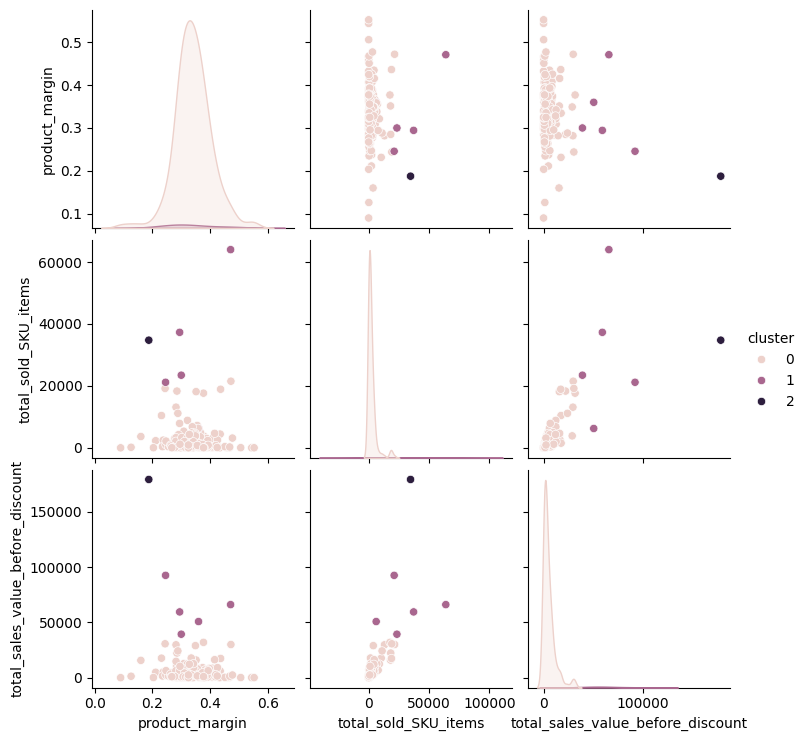

,total_categories,min_product_margin,max_product_margin,min_total_sold_SKU_items,max_total_sold_SKU_items,min_total_sales_value_before_discount,max_total_sales_value_before_discount
cluster,,,,,,,
0,185,0.08964,0.55178,2,21503,13.95544,31896.29870
1,5,0.24528,0.47040,6246,63956,39269.46929,92409.19882
2,1,0.18714,0.18714,34741,34741,179001.46738,179001.46738


In [64]:
df_sda_promo_cluster =  df_sda_clean.copy()

df_sda_promo_cluster = df_sda_promo_cluster.groupby(by=['Category level 0-2']).agg(
    total_sold_SKU_items = ('# of sold SKU items','sum'),
    total_unique_SKU_listed = ('Unique SKUs Listed','sum'),
    total_sales_value_before_discount = ('Sales Value Before Discount (includ. VAT) (EUR)','sum'),
    total_sales_value_after_discount = ('Sales Value After Discount (includ. VAT) (EUR)','sum'),
    total_discount_value = ('Discount Value (EUR)','sum'),
    total_item_COGS = ('Item COGS (net VAT) (EUR)','sum')
    ).reset_index()

df_sda_promo_cluster['total_profit'] = df_sda_promo_cluster['total_sales_value_after_discount'] - df_sda_promo_cluster['total_item_COGS']

df_sda_promo_cluster['product_margin'] = (df_sda_promo_cluster['total_sales_value_after_discount'] - df_sda_promo_cluster['total_item_COGS']) / df_sda_promo_cluster['total_sales_value_after_discount']

df_sda_promo_cluster = df_sda_promo_cluster.loc[
    df_sda_promo_cluster['product_margin'] > 0
]


data = df_sda_promo_cluster[[
    'product_margin',
    'total_sold_SKU_items',
    'total_sales_value_before_discount'
]]
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,n_init='auto')
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


kmeans = KMeans(n_clusters=3,n_init='auto')
kmeans.fit(data)

df_sda_promo_cluster['cluster'] = kmeans.labels_

sns.pairplot(
    df_sda_promo_cluster[[
    'product_margin',
    'total_sold_SKU_items',
    'total_sales_value_before_discount',
    'cluster'
]],
    hue='cluster'
)

plt.show()

df_sda_promo_cluster[[
    'product_margin',
    'total_sold_SKU_items',
    'total_sales_value_before_discount',
    'cluster'
]].groupby(by='cluster').agg(
    total_categories = ('cluster','count'),
    min_product_margin = ('product_margin','min'),
    max_product_margin = ('product_margin','max'),
    min_total_sold_SKU_items = ('total_sold_SKU_items','min'),
    max_total_sold_SKU_items = ('total_sold_SKU_items','max'),
    min_total_sales_value_before_discount = ('total_sales_value_before_discount','min'),
    max_total_sales_value_before_discount = ('total_sales_value_before_discount','max'),
)

In [66]:
df_sda_promo_cluster[df_sda_promo_cluster['cluster']==2] # Special Case. Regulatory prices. 
df_sda_promo_cluster[df_sda_promo_cluster['cluster']==1] # Good Product Margin, High Sold SKUs volume, High Sale Value. Major Categories Level 2. The Stars category. 
df_sda_promo_cluster[df_sda_promo_cluster['cluster']==0] # Good Product Margin, Good Sold SKUs volume, Good Sale Value. Important Categories Level 2 for company. 
# df_sda_promo_cluster[df_sda_promo_cluster['cluster']==1] # Other categories, important for the business revenue, but it is not the core. Long Tail Sortiment.

df_sda_promo_cluster[df_sda_promo_cluster['cluster']==2]

,Category level 0-2,total_sold_SKU_items,total_unique_SKU_listed,total_sales_value_before_discount,total_sales_value_after_discount,total_discount_value,total_item_COGS,total_profit,product_margin,cluster
184,Grocery Non-Food|Tobacco & Heated Tobacco|Cigarettes & Cigars,34741,6837,179001.46738,179711.36490,-709.89752,146079.61857,33631.74633,0.18714,2


## Waste Management

In [88]:
df_sda_waste = df_sda_clean.copy()
df_sda_waste = df_sda_waste.dropna()



df_sda_waste_cat0 = df_sda_waste.groupby(by=['Category level 0']).agg(
    total_waste = ('Waste, # of items','sum')
).reset_index().sort_values(by='total_waste',ascending=False)

df_sda_waste_cat1 = df_sda_waste.groupby(by=['Category level 0-1']).agg(
    total_waste = ('Waste, # of items','sum')
).reset_index().sort_values(by='total_waste',ascending=False)

NameError: name 'ts' is not defined

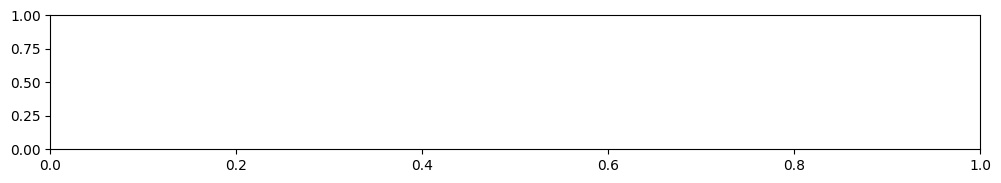

In [75]:
df_sda_forecast = df_sda_clean.copy()

df_sda_forecast = df_sda_forecast.groupby(by=['Time','Category level 0-1']).agg(
    total_sold_SKU_items = ('# of sold SKU items','sum')
    ).reset_index()


df_sda_forecast = df_sda_forecast.loc[
    df_sda_forecast['Category level 0-1'] =='Fresh Food|Fruits & Vegetables'
]


df_sda_forecast = df_sda_forecast[[
    'Time',
    'total_sold_SKU_items'
]].sort_values(by='Time').reset_index(drop=True)

df_sda_forecast.index = pd.to_datetime(df_sda_forecast['Time'], format='%Y-%m-%d')
df_sda_forecast.index = pd.date_range(start='2023-07-03', end='2023-09-29')
del df_sda_forecast['Time']



# np.isfinite(df_sda_forecast).drop_duplicates()

train = df_sda_forecast[df_sda_forecast.index <= pd.to_datetime("2023-09-01", format='%Y-%m-%d')]
test = df_sda_forecast[df_sda_forecast.index >= pd.to_datetime("2023-09-01", format='%Y-%m-%d')]
y = train


# Perform seasonal decomposition (additive model)
train2 = train

# train2.sort_values(by='total_sold_SKU_items')
result_add = seasonal_decompose(train2, model='additive')

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(ts, label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result_add.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result_add.seasonal, label='Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result_add.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()


from statsmodels.tsa.stattools import adfuller
dftest = adfuller(train2, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

p = 0
d = 2
q = 2

# ACF and PACF plots
plot_acf(train2, lags=20)
plt.show()

plot_pacf(train2, lags=20)
plt.show()


plt.plot(train, color = "black")
plt.ylabel('Total Sold SKU')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions for Total Sold SKU")


SARIMAXmodel = SARIMAX(y, order = (1, 1, 1), seasonal_order=(1, 1, 1,10))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.plot(test, color='Red', label = 'Test')
# plt.plot(y_pred_lower, color='Red', label = 'SARIMA Lower Predictions')
# plt.plot(y_pred_upper, color='Red', label = 'SARIMA Upper Predictions')
plt.legend()
plt.show()